In [1]:
from typing import Tuple
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms

from kedro.extras.datasets.pandas import CSVDataSet

In [2]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.data import AcdcEvaluator, ScdEvaluator, MnmEvaluator

In [3]:
pi = pd.read_csv('../data/01_raw/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv', index_col=0)

In [4]:
pi.head()

,External code,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
0,A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0
1,A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
2,A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
3,A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0
4,A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN


In [5]:
!rm -rf ../data/03_primary/mnm_test/
!rm ../data/03_primary/mnm_test.csv

In [6]:
mnm = MnmEvaluator(
    filepath='../data/03_primary/mnm_test.csv',
    load_args=dict(
        filepath_raw='../data/01_raw/OpenDataset/Testing',
        patient_info='../data/01_raw/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv'
    )
).load()

100%|██████████| 136/136 [05:28<00:00,  2.41s/patient]


In [7]:
mnm

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight,image_path,label_path
0,Philips,B,3,23,7,36,DCM,M,NaN,67.0,/workspace/dev/tagseg/data/03_primary/mnm_test...,/workspace/dev/tagseg/data/03_primary/mnm_test...
1,Philips,B,3,23,7,36,DCM,M,NaN,67.0,/workspace/dev/tagseg/data/03_primary/mnm_test...,/workspace/dev/tagseg/data/03_primary/mnm_test...
2,Philips,B,3,23,7,36,DCM,M,NaN,67.0,/workspace/dev/tagseg/data/03_primary/mnm_test...,/workspace/dev/tagseg/data/03_primary/mnm_test...
3,Philips,B,3,23,7,36,DCM,M,NaN,67.0,/workspace/dev/tagseg/data/03_primary/mnm_test...,/workspace/dev/tagseg/data/03_primary/mnm_test...
4,Philips,B,3,23,7,36,DCM,M,NaN,67.0,/workspace/dev/tagseg/data/03_primary/mnm_test...,/workspace/dev/tagseg/data/03_primary/mnm_test...
...,...,...,...,...,...,...,...,...,...,...,...,...
2231,Philips,B,2,29,11,75,HCM,M,NaN,90.0,/workspace/dev/tagseg/data/03_primary/mnm_test...,/workspace/dev/tagseg/data/03_primary/mnm_test...
2232,Philips,B,2,29,11,75,HCM,M,NaN,90.0,/workspace/dev/tagseg/data/03_primary/mnm_test...,/workspace/dev/tagseg/data/03_primary/mnm_test...
2233,Philips,B,2,29,11,75,HCM,M,NaN,90.0,/workspace/dev/tagseg/data/03_primary/mnm_test...,/workspace/dev/tagseg/data/03_primary/mnm_test...
2234,Philips,B,2,29,11,75,HCM,M,NaN,90.0,/workspace/dev/tagseg/data/03_primary/mnm_test...,/workspace/dev/tagseg/data/03_primary/mnm_test...


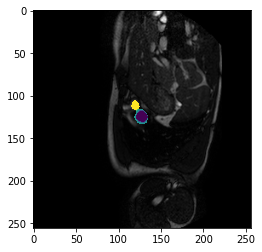

In [8]:
plt.imshow(np.load(mnm.iloc[0].image_path), cmap='gray')
label = np.load(mnm.iloc[0].label_path)
plt.imshow(np.ma.masked_where(label == 0, label), cmap='viridis') 

In [5]:
scd = ScdEvaluator(
    filepath='../data/03_primary/scd_test.csv',
    load_args=dict(
        filepath_raw=['../data/01_raw/sunnybrook/testing'],
        patient_info='../data/01_raw/sunnybrook/scd_patientdata.xlsx'
    )
).load()

In [ ]:
acdc = AcdcEvaluator(
    filepath='../data/03_primary/acdc_test.csv',
    load_args=dict(filepath_raw='../data/01_raw/acdc-testing')
).load()